In [2]:
import multiprocessing
import time
import random
import os

import matplotlib.pyplot as plt
import matplotlib.patches as patches

import mxnet as mx
import numpy as np
from skimage.draw import line_aa
from skimage import transform as skimage_transform

from mxnet import nd, autograd, gluon
from mxnet.image import resize_short
from mxboard import SummaryWriter

ctx = mx.gpu()
mx.random.seed(1)

from utils.iam_dataset import IAMDataset
from utils.iou_loss import IOU_loss
from utils.draw_box_on_image import draw_box_on_image

model_checkpoint_folder = "model_checkpoint"
if not os.path.isdir(model_checkpoint_folder):
    os.makedirs(model_checkpoint_folder)

# Paragraph Segmentation
This notebook investigates methods to identify segment handwritten passages from images that contains printed and handwritten text using **DCNN**

*Input*: a png from the IAM dataset with the "form" input and output type of "bb" and form.

*Output*: a bounding boxes of the paragraphs.

## Dataset creation

In [3]:
train_ds = IAMDataset("form", output_data="bb", output_parse_method="form", train=True)
print("Number of training samples: {}".format(len(train_ds)))

test_ds = IAMDataset("form", output_data="bb", output_parse_method="form", train=False)
print("Number of testing samples: {}".format(len(test_ds)))

Number of training samples: 967
Number of testing samples: 232


Two transforms were used, the "transform" function only resizes and normalises the image. The "augment_transform" function randomly shifts the image and predicted bounding box by 5% then called the "transform" function.

In [4]:
batch_size = 32

random_y_translation, random_x_translation = (0.05, 0.05) # Randomly translate the input image
expand_bb_scale = 0.03 # Expand the bounding box to relax the boundaries 

In [5]:
def transform(data, label):
    '''
    Function that converts "data"" into the input image tensor for a CNN
    Label is converted into a float tensor.
    '''
    image = mx.nd.array(data).expand_dims(axis=2)
    image = resize_short(image, int(800/3))
    image = image.transpose([2, 0, 1])/255.
    label = label[0].astype(np.float32)
    
    bb = label
    new_w = (1 + expand_bb_scale) * bb[2]
    new_h = (1 + expand_bb_scale) * bb[3]
    
    bb[0] = bb[0] - (new_w - bb[2])/2
    bb[1] = bb[1] - (new_h - bb[3])/2
    bb[2] = new_w
    bb[3] = new_h

    return image, mx.nd.array(bb)

def augment_transform(data, label):
    '''
    Function that randomly translates the input image by +-width_range and +-height_range.
    The labels (bounding boxes) are also translated by the same amount.
    '''
    ty = random.uniform(-random_y_translation, random_y_translation)
    tx = random.uniform(-random_x_translation, random_x_translation)
    st = skimage_transform.SimilarityTransform(translation=(tx*data.shape[1], ty*data.shape[0]))
    data = skimage_transform.warp(data, st)

    label[0][0] = label[0][0] - tx
    label[0][1] = label[0][1] - ty
    return transform(data*255., label)

In [6]:
train_data = gluon.data.DataLoader(train_ds.transform(augment_transform), batch_size, shuffle=True, num_workers=multiprocessing.cpu_count())
test_data = gluon.data.DataLoader(test_ds.transform(transform), batch_size, shuffle=False, num_workers=multiprocessing.cpu_count())

## Network creation

In [7]:
def make_cnn():
    p_dropout = 0.5

    cnn = gluon.nn.HybridSequential()
    cnn.add(gluon.nn.Conv2D(kernel_size=(3,3), padding=(1,1), channels=16, activation="relu"))
    cnn.add(gluon.nn.BatchNorm())

    cnn.add(gluon.nn.Conv2D(kernel_size=(3,3), padding=(1,1), channels=16, activation="relu"))
    cnn.add(gluon.nn.BatchNorm())

    cnn.add(gluon.nn.Conv2D(kernel_size=(3,3), padding=(1,1), channels=16, activation="relu"))
    cnn.add(gluon.nn.BatchNorm())

    cnn.add(gluon.nn.Conv2D(kernel_size=(3,3), padding=(1,1), channels=16, activation="relu"))
    cnn.add(gluon.nn.MaxPool2D(pool_size=(2,2), strides=(2,2)))
    cnn.add(gluon.nn.BatchNorm())

    cnn.add(gluon.nn.Conv2D(kernel_size=(3,3), padding=(1,1), channels=16, activation="relu"))
    cnn.add(gluon.nn.MaxPool2D(pool_size=(2,2), strides=(2,2)))
    cnn.add(gluon.nn.BatchNorm())

    cnn.add(gluon.nn.Flatten())
    cnn.add(gluon.nn.Dense(64, activation='relu'))
    cnn.add(gluon.nn.Dropout(p_dropout))
    cnn.add(gluon.nn.Dense(64, activation='relu'))
    cnn.add(gluon.nn.Dropout(p_dropout))
    cnn.add(gluon.nn.Dense(4, activation='sigmoid'))

    cnn.hybridize()
    cnn.collect_params().initialize(mx.init.Normal(), ctx=ctx)
    return cnn

cnn = make_cnn()

## Define epoch

In [9]:
print_every_n = 20
send_image_every_n = 20
save_every_n = 100

def run_epoch(e, network, dataloader, loss_function, trainer, log_dir, print_name, update_cnn, save_cnn):
    total_loss = nd.zeros(1, ctx)
    for i, (data, label) in enumerate(dataloader):
        data = data.as_in_context(ctx)
        label = label.as_in_context(ctx)
        
        with autograd.record():
            output = network(data)
            loss_i = loss_function(output, label)
        if update_cnn:
            loss_i.backward()
            trainer.step(data.shape[0])

        total_loss += loss_i.mean()
        
        if e % send_image_every_n == 0 and e > 0 and i == 0:
            output_image = draw_box_on_image(output.asnumpy(), label.asnumpy(), data.asnumpy())
    epoch_loss = float(total_loss .asscalar())/len(dataloader)
    
    with SummaryWriter(logdir=log_dir, verbose=False, flush_secs=5) as sw:
        sw.add_scalar('loss', {print_name: epoch_loss}, global_step=e)
        if e % send_image_every_n == 0 and e > 0:
            output_image[output_image<0] = 0
            output_image[output_image>1] = 1
            sw.add_image('bb_{}_image'.format(print_name), output_image, global_step=e)
            
    if save_cnn and e % save_every_n == 0 and e > 0:
        network.save_params("{}/{}".format(model_checkpoint_folder, checkpoint_name))
    return epoch_loss

## Pre training
The network was initially trained on 300 epochs using the Mean squared error (L2 loss) as a loss function. This was performed because without reasonable bounding boxes (ie. overlapping bounding boxes), the IOU loss will not function properly. 

In [10]:
checkpoint_name = "cnn_mse.params"
loss_function = gluon.loss.L2Loss()
epochs = 301
learning_rate = 0.001
log_dir = "./logs"

trainer = gluon.Trainer(cnn.collect_params(), 'adam', {'learning_rate': learning_rate, })

for e in range(epochs):
    train_loss = run_epoch(e, cnn, train_data, loss_function=loss_function, log_dir=log_dir, 
                           trainer=trainer, print_name="train", update_cnn=True, save_cnn=True)
    test_loss = run_epoch(e, cnn, test_data, loss_function=loss_function, log_dir=log_dir,
                          trainer=trainer, print_name="test", update_cnn=False, save_cnn=False)
    if e % print_every_n == 0 and e > 0:
        print("Epoch {0}, train_loss {1:.6f}, test_loss {2:.6f}".format(e, train_loss, test_loss))

Epoch 20, train_loss 0.002078, test_loss 0.001994
Epoch 40, train_loss 0.001411, test_loss 0.001570
Epoch 60, train_loss 0.001012, test_loss 0.001199
Epoch 80, train_loss 0.000741, test_loss 0.001462
Epoch 100, train_loss 0.000600, test_loss 0.001201
Epoch 120, train_loss 0.000511, test_loss 0.000802
Epoch 140, train_loss 0.000458, test_loss 0.000671
Epoch 160, train_loss 0.000452, test_loss 0.000566
Epoch 180, train_loss 0.000408, test_loss 0.000608
Epoch 200, train_loss 0.000416, test_loss 0.000457
Epoch 220, train_loss 0.000371, test_loss 0.000460
Epoch 240, train_loss 0.000363, test_loss 0.000408
Epoch 260, train_loss 0.000348, test_loss 0.000514
Epoch 280, train_loss 0.000357, test_loss 0.000457
Epoch 300, train_loss 0.000339, test_loss 0.000426


### Fine tuning
After training the network with the mean squared error loss, the IOU loss was used to fine tune the network. The IOU loss is more finegrained as it maximises the overlap between the bounding boxes.

In [11]:
cnn.load_params("model_checkpoint/{}".format(checkpoint_name))

In [12]:
checkpoint_name = "cnn_iou.params"

loss_function = IOU_loss()
epochs = 150
learning_rate = 0.0001
log_dir = "./logs"

trainer = gluon.Trainer(cnn.collect_params(), 'adam', {'learning_rate': learning_rate, })

for e in range(epochs):
    train_loss = run_epoch(e, cnn, train_data, loss_function=loss_function, log_dir=log_dir, 
                           trainer=trainer, print_name="train", update_cnn=True, save_cnn=True)
    test_loss = run_epoch(e, cnn, test_data, loss_function=loss_function, log_dir=log_dir,
                          trainer=trainer, print_name="test", update_cnn=False, save_cnn=False)
    if e % print_every_n == 0 and e > 0:
        print("Epoch {0}, train_loss {1:.6f}, test_loss {2:.6f}".format(e, train_loss, test_loss))

Epoch 20, train_loss 0.140906, test_loss 0.160152
Epoch 40, train_loss 0.136595, test_loss 0.144321
Epoch 60, train_loss 0.134104, test_loss 0.157972
Epoch 80, train_loss 0.136537, test_loss 0.155280
Epoch 100, train_loss 0.131479, test_loss 0.146853
Epoch 120, train_loss 0.128704, test_loss 0.163886
Epoch 140, train_loss 0.130897, test_loss 0.156916


## Results
The training and test MSE is printed out in this notebook. The loss and the images with predicted bounding boxes is shown on below. Both this information can be viewed on [mxboard](https://medium.com/apache-mxnet/mxboard-mxnet-data-visualization-2eed6ae31d2c) while the network is training. 

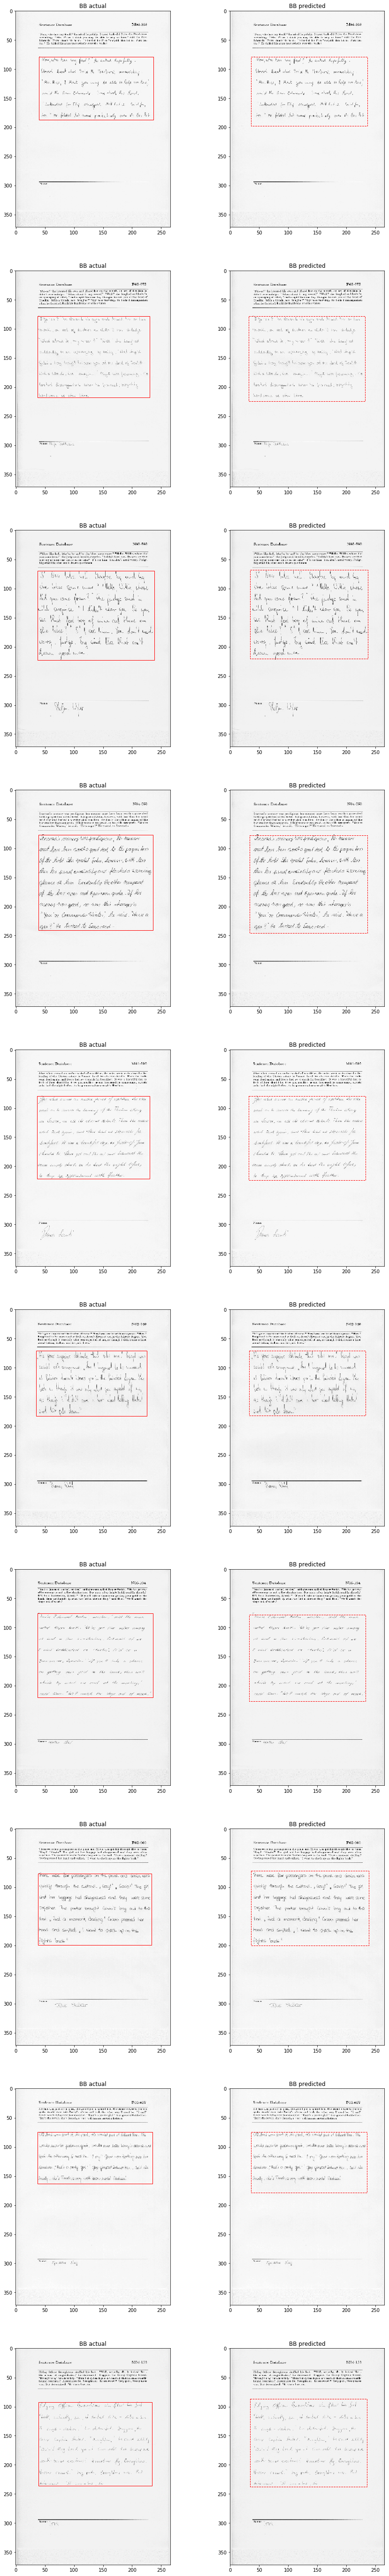

In [14]:
figs_to_plot = 10
fig, axs = plt.subplots(figs_to_plot, 2, figsize=(15, 10 * figs_to_plot))

for i in range(figs_to_plot):
    n = int(random.random()*len(test_ds))
    image, bb = test_ds[n]

    image, _ = transform(image, bb)
    image = image.as_in_context(ctx)
    image = image.expand_dims(axis=0)
    bb_predicted = cnn(image)

    (x, y, w, h) = bb[0]
    axs[i][0].imshow(image.asnumpy().squeeze(), cmap='Greys_r')
    image_h, image_w = image.shape[-2:]
    (x, y, w, h) = (x * image_w, y * image_h, w * image_w, h * image_h)
    rect = patches.Rectangle((x, y), w, h, fill=False, color="r")
    axs[i][0].add_patch(rect)
    axs[i][0].set_title("BB actual")

    axs[i][1].imshow(image.asnumpy().squeeze(), cmap='Greys_r')
    (x, y, w, h) = bb_predicted[0].asnumpy()
    image_h, image_w = image.shape[-2:]
    (x, y, w, h) = (x * image_w, y * image_h, w * image_w, h * image_h)
    rect = patches.Rectangle((x, y), w, h, fill=False, color="r", ls="--")
    axs[i][1].add_patch(rect)
    axs[i][1].set_title("BB predicted")